**🧩 Step 1: Collect Historical Forex Data**

You need data for one or more currency pairs (e.g., EUR/USD, USD/INR, etc.).

📊 Option 1: Download from Yahoo Finance

You can get free forex data using yfinance library in Python.

In [22]:
pip install yfinance


In [3]:
import yfinance as yf

# Download EUR/USD data for last 5 years (daily)
data = yf.download("EURUSD=X", start="2020-01-01", end="2025-01-01")

print(data.head())


/tmp/ipython-input-4211127512.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("EURUSD=X", start="2020-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed

Price          Close      High       Low      Open   Volume
Ticker      EURUSD=X  EURUSD=X  EURUSD=X  EURUSD=X EURUSD=X
Date                                                       
2020-01-01  1.122083  1.122838  1.115947  1.122083        0
2020-01-02  1.122083  1.122712  1.116682  1.121894        0
2020-01-03  1.117144  1.118068  1.112570  1.117081        0
2020-01-06  1.116196  1.120825  1.115810  1.116246        0
2020-01-07  1.119799  1.119946  1.113487  1.119583        0


**🧩 Step 2: Data Preprocessing**

This step is all about cleaning and preparing your forex dataset before feeding it into a machine learning model.

🧹 Step 2.1 — Check for Missing or Invalid Values

In [4]:
# Check if there are any missing values
print(data.isnull().sum())

# Drop missing rows if any
data = data.dropna()

# Confirm cleaning
print("After cleaning:", data.shape)


Price   Ticker  
Close   EURUSD=X    0
High    EURUSD=X    0
Low     EURUSD=X    0
Open    EURUSD=X    0
Volume  EURUSD=X    0
dtype: int64
After cleaning: (1305, 5)


📅 Step 2.2 — Convert Date Index (if not already)

Sometimes the Date column is in the index.

In [5]:
# Reset index to make 'Date' a normal column
data = data.reset_index()
print(data.head())


Price        Date     Close      High       Low      Open   Volume
Ticker             EURUSD=X  EURUSD=X  EURUSD=X  EURUSD=X EURUSD=X
0      2020-01-01  1.122083  1.122838  1.115947  1.122083        0
1      2020-01-02  1.122083  1.122712  1.116682  1.121894        0
2      2020-01-03  1.117144  1.118068  1.112570  1.117081        0
3      2020-01-06  1.116196  1.120825  1.115810  1.116246        0
4      2020-01-07  1.119799  1.119946  1.113487  1.119583        0


📊 Step 2.3 — Keep Only the Needed Columns

For our first model, we’ll use Close price only (simplest approach).

In [6]:
# Select only the 'Date' and 'Close' columns
data = data[['Date', 'Close']]


⚙️ Step 2.4 — Create Features and Targets

We need to turn this time-series into a supervised learning dataset.

We’ll predict tomorrow’s price using the previous 5 days.

In [7]:
import pandas as pd

# Create lag features (previous 5 days)
for i in range(1, 6):
    data[f'lag_{i}'] = data['Close'].shift(i)

# Drop missing rows after shifting
data = data.dropna()

# Target: next day's close price
X = data[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']]
y = data['Close']


📈 Step 2.5 — Train/Test Split

We’ll split the data to train and test your model later.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


**🧩 Step 3: Model Building (Linear Regression)**

📌 Step 3.1 — Import Libraries

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


📌 Step 3.2 — Create and Train the Model

In [10]:
# Initialize the Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)


LinearRegression()

📌 Step 3.3 — Make Predictions

In [11]:
# Predict on test data
y_pred = model.predict(X_test)


📌 Step 3.4 — Evaluate the Model

In [12]:
# Calculate RMSE and R^2 score
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R^2 Score: {r2}")


RMSE: 0.004014020749912682
R^2 Score: 0.9481123254970558


📌 Step 3.5 — Plot Predictions vs Actual Prices

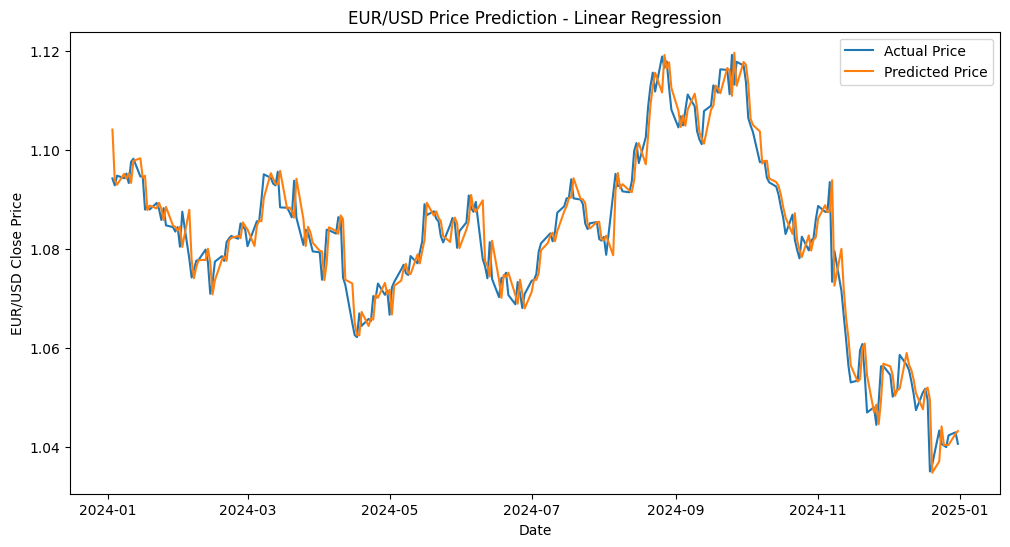

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(data['Date'].iloc[-len(y_test):], y_test, label='Actual Price')
plt.plot(data['Date'].iloc[-len(y_test):], y_pred, label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('EUR/USD Close Price')
plt.title('EUR/USD Price Prediction - Linear Regression')
plt.legend()
plt.show()


**🧩 Step 4: LSTM Model for Forex Prediction**

📌 Step 4.1 — Install Libraries

In [14]:
pip install tensorflow


📌 Step 4.2 — Import Libraries

In [15]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


📌 Step 4.3 — Prepare Data for LSTM

LSTM works best with normalized data and 3D input: (samples, timesteps, features).

In [17]:
# Use 'Close' price only
data_lstm = data[['Close']].values

# Normalize data between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data_lstm)

# Create sequences (lookback = 60 days)
X_lstm = []
y_lstm = []

lookback = 60

for i in range(lookback, len(data_scaled)):
    X_lstm.append(data_scaled[i-lookback:i, 0])
    y_lstm.append(data_scaled[i, 0])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Reshape for LSTM (samples, timesteps, features)
X_lstm = np.reshape(X_lstm, (X_lstm.shape[0], X_lstm.shape[1], 1))

# Split into train/test (80/20)
split = int(0.8 * len(X_lstm))
X_train, X_test = X_lstm[:split], X_lstm[split:]
y_train, y_test = y_lstm[:split], y_lstm[split:]


In [ ]:
📌 Step 4.4 — Build LSTM Model

In [18]:
model = Sequential()

# First LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - loss: 0.1371 - val_loss: 0.0024
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - loss: 0.0110 - val_loss: 0.0027
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.0071 - val_loss: 0.0014
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0055 - val_loss: 0.0014
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0059 - val_loss: 0.0018
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0056 - val_loss: 0.0013
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0052 - val_loss: 0.0013
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0046 - val_loss: 0.0012
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0048 - val_loss: 0.0012
Epoch 10/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0047 - val_loss: 0.0012
Epoch 11/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0046 - val_loss: 0.0013
Epoch 12/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0041 - val

📌 Step 4.5 — Predict and Inverse Transform

In [19]:
# Make predictions
y_pred = model.predict(X_test)

# Reverse scaling
y_pred_scaled = scaler.inverse_transform(y_pred.reshape(-1,1))
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1,1))


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


📌 Step 4.6 — Plot Predictions vs Actual

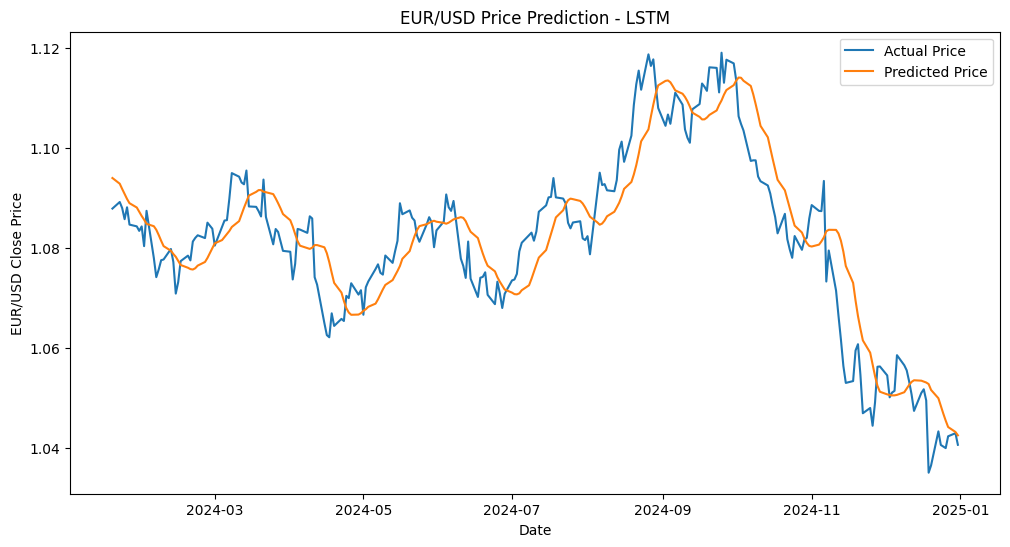

In [20]:
plt.figure(figsize=(12,6))
plt.plot(data['Date'].iloc[-len(y_test_scaled):], y_test_scaled, label='Actual Price')
plt.plot(data['Date'].iloc[-len(y_test_scaled):], y_pred_scaled, label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('EUR/USD Close Price')
plt.title('EUR/USD Price Prediction - LSTM')
plt.legend()
plt.show()


**🧩 Step 5: Trading Strategy & Backtesting**

We’ll use a simple strategy first:

Buy if the model predicts the next day’s price will go up

Sell if the model predicts the next day’s price will go down

In [21]:
# Create a DataFrame for test results
results = pd.DataFrame({
    'Date': data['Date'].iloc[-len(y_test_scaled):].values,
    'Actual': y_test_scaled.flatten(),
    'Predicted': y_pred_scaled.flatten()
})

# Generate signals: 1 = Buy, -1 = Sell
results['Signal'] = 0
results.loc[results['Predicted'] > results['Actual'], 'Signal'] = 1
results.loc[results['Predicted'] < results['Actual'], 'Signal'] = -1

print(results.head(10))


        Date    Actual  Predicted  Signal
0 2024-01-19  1.087914   1.094032       1
1 2024-01-22  1.089230   1.092892       1
2 2024-01-23  1.088021   1.091844       1
3 2024-01-24  1.085788   1.090853       1
4 2024-01-25  1.088175   1.089836       1
5 2024-01-26  1.084705   1.088993       1
6 2024-01-29  1.084352   1.088128       1
7 2024-01-30  1.083447   1.087278       1
8 2024-01-31  1.084340   1.086435       1
9 2024-02-01  1.080392   1.085697       1


📌 Step 5.2 — Calculate Returns

In [24]:
# Calculate daily returns
results['Return'] = results['Actual'].pct_change()

# Strategy returns
results['Strategy_Return'] = results['Return'] * results['Signal'].shift(1)

# Cumulative returns
results['Cumulative_Market'] = (1 + results['Return']).cumprod()
results['Cumulative_Strategy'] = (1 + results['Strategy_Return']).cumprod()


📌 Step 5.3 — Plot Strategy Performance

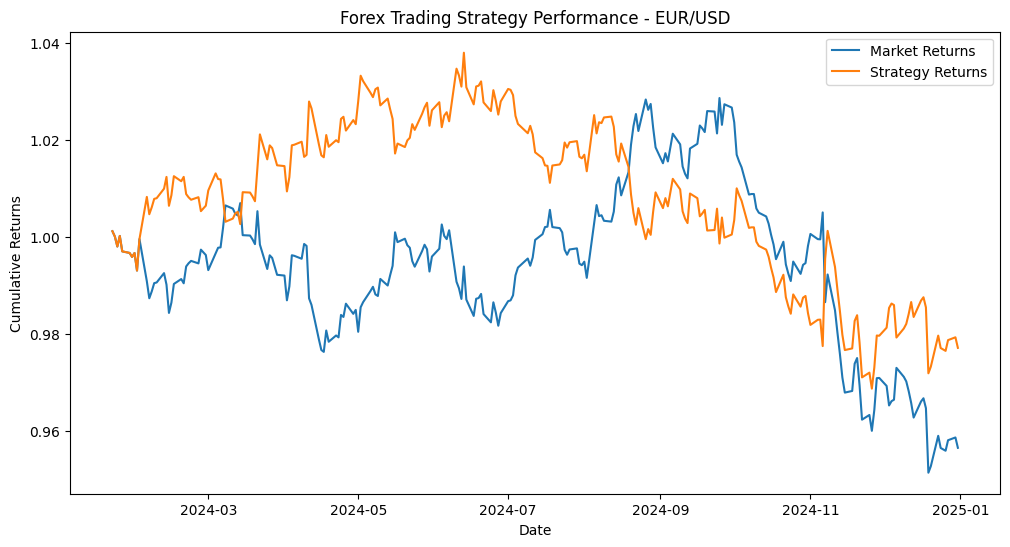

In [25]:
plt.figure(figsize=(12,6))
plt.plot(results['Date'], results['Cumulative_Market'], label='Market Returns')
plt.plot(results['Date'], results['Cumulative_Strategy'], label='Strategy Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Forex Trading Strategy Performance - EUR/USD')
plt.legend()
plt.show()


📌 Step 5.4 — Evaluate Performance

In [26]:
total_return = results['Cumulative_Strategy'].iloc[-1] - 1
market_return = results['Cumulative_Market'].iloc[-1] - 1

print(f"Strategy Total Return: {total_return*100:.2f}%")
print(f"Market Total Return: {market_return*100:.2f}%")


Strategy Total Return: -2.29%
Market Total Return: -4.35%
